# Noisy-And MIL

Now we're going to load and train and MIL network on MNIST (presence of 0 = positive bag).

In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
import tensorflow_addons as tfa
from noisy_and import NoisyAnd
from tensorflow.keras import layers
from utils import plot_results
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

N_CLASSES = 2
MAX_BAG = 7

print(tf.__version__)

2.4.1


In [2]:
def preprocess_mil(dataset, prefix, noise):
  (x_train, _), (x_test, _) = dataset

  # Standardize
  x_train = x_train[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_train[..., np.newaxis]).numpy()
  x_test = x_test[..., np.newaxis] / 255 #tf.image.per_image_standardization(x_test[..., np.newaxis]).numpy()
  
  x_train, y_train = load_mil(x_train, prefix + '_train.csv', noise)
  x_test, y_test = load_mil(x_test, prefix + '_test.csv', None)
  

  return (x_train, y_train), (x_test, y_test)

def load_mil(x_orig, csv, noise):
  df = pd.read_csv(csv)
  
  x = np.zeros((df.shape[0], MAX_BAG) +  x_orig[0].shape)
  for i, r in df.iterrows():
    idx = r[1:][r[1:] != -1]
    x[i, :idx.shape[0]] = x_orig[idx]
  
  y = df.y.values
  
  if noise:
    mask = np.random.rand(y.shape[0]) <= noise
    y[mask] = y[mask]^1
  
  y = tf.one_hot(y, N_CLASSES).numpy()
  
  return x, y

def load_fashion(noise):
  def load():
    return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/fashion', noise)
  return load

def load_mnist(noise):
  def load():
    return preprocess_mil(tf.keras.datasets.mnist.load_data(), 'data/mnist', noise)
  return load

def load_outfit(noise):
  def load():
    return preprocess_mil(tf.keras.datasets.fashion_mnist.load_data(), 'data/outfit', noise)
  return load

In [3]:
def evaluate(create_model, load_dataset, epochs=10, batch_size=64):
  (x_train, y_train), (x_test, y_test) = load_dataset()
  
  print('----- Data -----')
  print(f'Train : x={x_train.shape}, y={y_train.shape}')
  print(f'Test  : x={x_test.shape}, y={y_test.shape}')
  print(f'Splits: train={y_train.sum(axis=0).astype(int)}, test={y_test.sum(axis=0).astype(int)}')
  print('----------------') 

  model = create_model()

  return model.fit(
      x_train, y_train,
      callbacks=[ tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      ) ],
      validation_data=(x_test, y_test),
      epochs=epochs,
      batch_size=batch_size,
  )

In [4]:
def get_metrics(histories):
  noises = np.zeros(len(histories))
  trn_f1s = np.zeros(len(histories))
  tst_f1s = np.zeros(len(histories))
  trn_aucs = np.zeros(len(histories))
  tst_aucs = np.zeros(len(histories))

  for i, (noise, history) in enumerate(histories.items()):
    noises[i] = noise
    trn_f1s[i] = max([np.mean(f) for f in history.history['f1']])
    tst_f1s[i] = max([np.mean(f) for f in history.history['val_f1']])
    trn_aucs[i] = max(history.history['auc'])
    tst_aucs[i] = max(history.history['val_auc'])
  
  return noises, (trn_f1s, tst_f1s), (trn_aucs, tst_aucs)
  
def plot(histories, title, filename=None):
  noises, (trn_f1s, tst_f1s), (trn_aucs, tst_aucs) = get_metrics(histories)
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

  axes[0].plot(noises, trn_f1s)
  axes[0].plot(noises, tst_f1s)
  axes[0].legend(['Train', 'Test'])
  axes[0].set_title('F1')
  axes[0].set_xticks(noises)
  axes[0].tick_params(labelrotation=45, axis='x')
  axes[0].set_xlabel('Noise')
  
  axes[1].plot(noises, trn_aucs)
  axes[1].plot(noises, tst_aucs)
  axes[1].legend(['Train', 'Test'])
  axes[1].set_title('AUC')
  axes[1].set_xticks(noises)
  axes[1].tick_params(labelrotation=45, axis='x')
  axes[1].set_xlabel('Noise')
  
  fig.suptitle(title, fontweight='bold')
  
  plt.show()
  plt.close()

In [5]:
def define_model():
  model = tf.keras.Sequential([
      layers.Input((MAX_BAG, 28, 28, 1)),
      layers.TimeDistributed(layers.Conv2D(64, 2, activation='relu', padding='same')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu')),
      layers.TimeDistributed(layers.MaxPool2D(2)),
      layers.TimeDistributed(layers.Dropout(0.3)),
      layers.TimeDistributed(layers.Flatten()),
      layers.TimeDistributed(layers.Dense(256, activation='relu')),
      layers.TimeDistributed(layers.Dropout(0.5)),
      layers.TimeDistributed(layers.Dense(N_CLASSES, activation='softmax')),
      NoisyAnd(N_CLASSES),
  ])
  
  model.compile(
      optimizer=tf.optimizers.Adam(),
      loss=tf.losses.CategoricalCrossentropy(),
      metrics=[
          tf.metrics.Precision(name='prec'),
          tf.metrics.Recall(name='rec'),
          tf.metrics.AUC(name='auc'),
          tfa.metrics.F1Score(N_CLASSES, name='f1'),
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.FalseNegatives(name='fn'),
      ],
  )
  return model

print(define_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 7, 28, 28, 64)     320       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14, 14, 64)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 12, 12, 32)     18464     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 6, 6, 32)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 1152)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 256)            2

Noise: 0.00
----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8365 4929], test=[1402  831]
----------------
Epoch 1/10
208/208 [==============================] - 43s 194ms/step - loss: 0.5075 - prec: 0.6306 - rec: 0.9758 - auc: 0.6986 - f1: 0.3976 - tp: 6550.8086 - tn: 3317.3589 - fp: 3402.1627 - fn: 168.7129 - val_loss: 0.3472 - val_prec: 0.7179 - val_rec: 0.9982 - val_auc: 0.7463 - val_f1: 0.3870 - val_tp: 2229.0000 - val_tn: 1357.0000 - val_fp: 876.0000 - val_fn: 4.0000
Epoch 2/10
208/208 [==============================] - 39s 187ms/step - loss: 0.3479 - prec: 0.7210 - rec: 0.9887 - auc: 0.7659 - f1: 0.4039 - tp: 6649.8804 - tn: 4131.6699 - fp: 2587.8517 - fn: 69.6411 - val_loss: 0.3167 - val_prec: 0.7197 - val_rec: 0.9991 - val_auc: 0.8711 - val_f1: 0.5617 - val_tp: 2231.0000 - val_tn: 1364.0000 - val_fp: 869.0000 - val_fn: 2.0000
Epoch 3/10
208/208 [==============================] - 39s 187ms/step - loss: 0.26

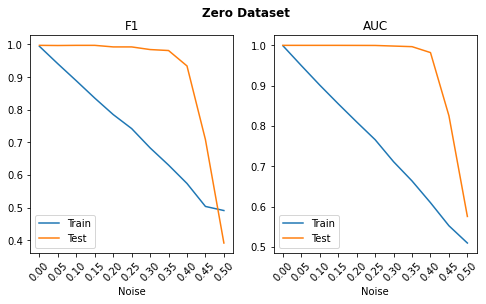

In [6]:
mnist_histories = {}

for i in range(11):
  noise = i / 20
  print(f'Noise: {noise:.2f}')
  history = evaluate(define_model, load_mnist(noise))
  mnist_histories[noise] = history
  
plot(mnist_histories, 'Zero Dataset')

Noise: 0.00
----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[8314 4980], test=[1400  833]
----------------
Epoch 1/10
208/208 [==============================] - 39s 182ms/step - loss: 0.5572 - prec: 0.5936 - rec: 0.9631 - auc: 0.6765 - f1: 0.4170 - tp: 6454.4067 - tn: 2791.0048 - fp: 3928.5167 - fn: 265.1148 - val_loss: 0.3709 - val_prec: 0.7138 - val_rec: 0.9897 - val_auc: 0.7448 - val_f1: 0.4034 - val_tp: 2210.0000 - val_tn: 1347.0000 - val_fp: 886.0000 - val_fn: 23.0000
Epoch 2/10
208/208 [==============================] - 37s 178ms/step - loss: 0.3709 - prec: 0.7120 - rec: 0.9848 - auc: 0.7741 - f1: 0.4145 - tp: 6615.5694 - tn: 4050.4163 - fp: 2669.1053 - fn: 103.9522 - val_loss: 0.3128 - val_prec: 0.7211 - val_rec: 0.9910 - val_auc: 0.8986 - val_f1: 0.5642 - val_tp: 2213.0000 - val_tn: 1377.0000 - val_fp: 856.0000 - val_fn: 20.0000
Epoch 3/10
208/208 [==============================] - 39s 185ms/step - loss: 0

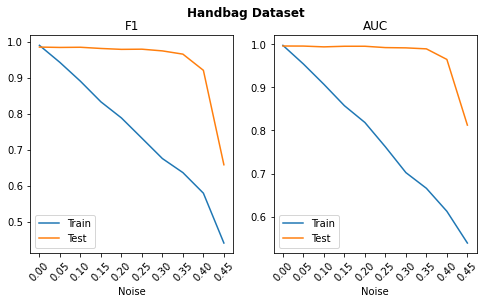

In [7]:
fashion_histories = {}

for i in range(10):
  noise = i / 20
  print(f'Noise: {noise:.2f}')
  history = evaluate(define_model, load_fashion(noise))
  fashion_histories[noise] = history
  
plot(fashion_histories, 'Handbag Dataset')

Noise: 0.00
----- Data -----
Train : x=(13294, 7, 28, 28, 1), y=(13294, 2)
Test  : x=(2233, 7, 28, 28, 1), y=(2233, 2)
Splits: train=[9987 3307], test=[1683  550]
----------------
Epoch 1/10
208/208 [==============================] - 42s 194ms/step - loss: 0.5164 - prec: 0.6219 - rec: 0.9233 - auc: 0.7742 - f1: 0.4362 - tp: 6280.5359 - tn: 3311.1340 - fp: 3408.3876 - fn: 438.9856 - val_loss: 0.3175 - val_prec: 0.7275 - val_rec: 0.9866 - val_auc: 0.8285 - val_f1: 0.4296 - val_tp: 2203.0000 - val_tn: 1408.0000 - val_fp: 825.0000 - val_fn: 30.0000
Epoch 2/10
208/208 [==============================] - 40s 190ms/step - loss: 0.3229 - prec: 0.7239 - rec: 0.9887 - auc: 0.8239 - f1: 0.4280 - tp: 6649.7368 - tn: 4190.8373 - fp: 2528.6842 - fn: 69.7847 - val_loss: 0.3105 - val_prec: 0.7264 - val_rec: 0.9893 - val_auc: 0.8293 - val_f1: 0.4296 - val_tp: 2209.0000 - val_tn: 1401.0000 - val_fp: 832.0000 - val_fn: 24.0000
Epoch 3/10
208/208 [==============================] - 38s 184ms/step - loss: 0.

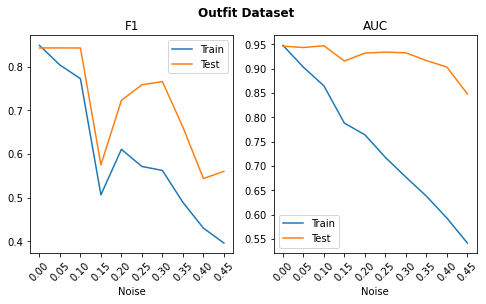

In [8]:
outfit_histories = {}

for i in range(10):
  noise = i / 20
  print(f'Noise: {noise:.2f}')
  history = evaluate(define_model, load_outfit(noise))
  outfit_histories[noise] = history
  
plot(outfit_histories, 'Outfit Dataset')

In [ ]:
def get_metrics(histories):
  noises = np.zeros(len(histories))
  trn_f1s = np.zeros(len(histories))
  tst_f1s = np.zeros(len(histories))
  trn_aucs = np.zeros(len(histories))
  tst_aucs = np.zeros(len(histories))

  for i, (noise, history) in enumerate(histories.items()):
    noises[i] = noise
    trn_f1s[i] = max([np.mean(f) for f in history.history['f1']])
    tst_f1s[i] = max([np.mean(f) for f in history.history['val_f1']])
    trn_aucs[i] = max(history.history['auc'])
    tst_aucs[i] = max(history.history['val_auc'])
  
  return noises, (trn_f1s, tst_f1s), (trn_aucs, tst_aucs)

noises, (mnist_trn_f1s, mnist_tst_f1s), (mnist_trn_aucs, mnist_tst_aucs) = get_metrics(mnist_histories)
_, (fashion_trn_f1s, fashion_tst_f1s), (fashion_trn_aucs, fashion_tst_aucs) = get_metrics(fashion_histories)
_, (outfit_trn_f1s, outfit_tst_f1s), (outfit_trn_aucs, outfit_tst_aucs) = get_metrics(outfit_histories)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

axes[0].set_title('Zero Dataset', fontweight='bold')
axes[1].set_title('Handbag Dataset', fontweight='bold')
axes[2].set_title('Outfits Dataset', fontweight='bold')

# axes[0, 0].set_ylabel('F1', fontweight='bold')
axes[0].set_ylabel('AUC', fontweight='bold')

axes[0].plot(noises, mnist_trn_aucs)
axes[0].plot(noises, mnist_tst_aucs)
axes[1].plot(noises, fashion_trn_aucs)
axes[1].plot(noises, fashion_tst_aucs)
axes[2].plot(noises, outfit_trn_aucs)
axes[2].plot(noises, outfit_tst_aucs)

for ax in axes.ravel():
  ax.set_xlabel('Noise')
  ax.set_xticks(noises)
  ax.tick_params(axis='x', labelrotation=45)
  ax.legend(['Train', 'Test'], loc='lower left')

plt.savefig('img/noisy-data.jpg', dpi=1000)
plt.show()
plt.close()